_author:_ Charles Gauvin

_date:_ February 6 2023


---

Notebook to showcase some of the features of the geohash_utils module

# Libs

In [1]:
import os
os.environ['PATH_TO_GIC'] = "/sidecar/home/charles.gauvin/Dev/GIC_VEXCEL"
import sys
sys.path.append(os.path.join(os.environ['PATH_TO_GIC'] , 'gic', 'geo_py_utils' ))

In [2]:
import geohash 
import pandas as pd
import numpy as np
import geopandas as gpd

from geo_py_utils.geo_general.bbox import get_list_coordinates_from_bbox, get_bbox_centroid
from geo_py_utils.geo_general.geo_utils import get_geodataframe_from_list_coord
from geo_py_utils.geo_general.map import map_simple
from geo_py_utils.geo_general.geohash_utils import (
    get_all_geohash_from_gdf,
    get_all_geohash_from_geohash_indices,
    recursively_partition_geohash_cells
)
from shapely.geometry import Point, Polygon


In [3]:
GEOHASH_PRECISION = 6

# First tests with geohashes

In [4]:
geohash_indices = ['f2k', 'f2m']
prec = list(set([len(p) for p in geohash_indices]))[0]

list_shp_children = []
list_geo = []
list_all_sub_geohash = []

for ind in geohash_indices:
        geo_shp_ = get_all_geohash_from_geohash_indices([ind])
        geo_shp_['index'] = ind
        list_geo.append(geo_shp_)

        geo_shp_all_ = get_all_geohash_from_gdf(geo_shp_, precision=prec+1)
        geo_shp_all_['parent'] = ind
        list_all_sub_geohash.append(geo_shp_all_)

        lng, lat = get_bbox_centroid(geo_shp_)
        geohash_indices_children = [cell for cell in
                                    geohash.neighbors(geohash.encode(lat, lng, precision=prec+1))]
        geo_shp_children_ = get_all_geohash_from_geohash_indices(
            geohash_indices_children)
        geo_shp_children_['parent'] = ind
        list_shp_children.append(geo_shp_children_)

geo_shp = pd.concat(list_geo)
geo_shp['parent_numeric'] = np.arange(geo_shp.shape[0])

geo_shp_children = pd.concat(list_shp_children)
geo_shp_children = geo_shp_children.merge(geo_shp[["index", "parent_numeric"]],
                                              left_on='parent', right_on='index')

geo_shp_all = pd.concat(list_all_sub_geohash)
geo_shp_all = geo_shp_all.merge(geo_shp[["index", "parent_numeric"]],
                                    left_on='parent', right_on='index')

In [5]:
map_simple({'original': geo_shp,
                "children": geo_shp_children,
                'all sub geohash': geo_shp_all},
               column_color='parent_numeric',
               tootltip_fields=['parent_numeric'])

# Recursive partition

In [21]:
shp_all_1 = gpd.GeoDataFrame(
        {
            'id': [0,1 ,2],
            "geometry": [Point (-71.16451, 46.86968),   Point (-71.25148, 48.41987), Point (-71.25148, 48.419)	], #slight tweak - same geohash 
            "counts": [1.0, 1.0, 1.0]
    }   ,
    crs = 4326
    )

shp_part, _ = recursively_partition_geohash_cells(shp_all_1,
                                                  count_column_name='counts',
                                                  min_num_points = 1,
                                                  max_precision=4)

/sidecar/home/charles.gauvin/Dev/GIC_VEXCEL/gic/geo_py_utils/geo_py_utils/geo_general/centroid.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_centroids = pd.DataFrame( [ (p.x,p.y) for p in shp.geometry.centroid])
/sidecar/home/charles.gauvin/Dev/GIC_VEXCEL/gic/geo_py_utils/geo_py_utils/geo_general/centroid.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_centroids = pd.DataFrame( [ (p.x,p.y) for p in shp.geometry.centroid])
/sidecar/home/charles.gauvin/Dev/GIC_VEXCEL/gic/geo_py_utils/geo_py_utils/geo_general/centroid.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this

Using the counts column for counts


/sidecar/home/charles.gauvin/Dev/GIC_VEXCEL/gic/geo_py_utils/geo_py_utils/geo_general/geohash_utils.py:558: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_layers[p].append(shp_count_by_hash_not_suff_precise)


In [22]:
shp_part[shp_part.counts>0]

,index,geometry,geohash_index,counts
5,5,"POLYGON ((-71.71875 46.40625, -71.71875 47.812...",f2m,1.0
4,4,"POLYGON ((-71.36719 48.33984, -71.36719 48.515...",f2t7,2.0


In [7]:
shp_bug = gpd.GeoDataFrame(
            {
            'id' :[0	,1,	2	,3],
            'geohash_index' : ["drgp",	"drgr",	"f0r9",	"f0rb"],
            "lat" : [44.997203	,44.996874	,46.722120	,46.521345],
            "lng": [-74.349024,	-74.084504,	-79.103772	,-78.868221],
            'counts' : [134, 410, 119	,59],
            'geometry': [Point(-74.34902, 44.99720),Point(-74.08450,44.99687),Point(-79.10377,46.72212),Point(-78.86822,46.52135)]
            },
            crs = 4326          
)
    
shp_part, _ = recursively_partition_geohash_cells(shp_bug,
                                                    count_column_name='counts',
                                                    min_num_points = 2)

Warning! Reached max geohahsh precision of 1 and the bounding box is still does not contained within a single geohash cell!
Warning in add_geohash_index! geohash_index  already exists - dropping and repopulating


Using the counts column for counts


Warning in add_geohash_index! geohash_index  already exists - dropping and repopulating
Warning in add_geohash_index! geohash_index  already exists - dropping and repopulating
Warning in add_geohash_index! geohash_index  already exists - dropping and repopulating
Warning in add_geohash_index! geohash_index  already exists - dropping and repopulating
Warning in add_geohash_index! geohash_index  already exists - dropping and repopulating
Warning in add_geohash_index! geohash_index  already exists - dropping and repopulating
Warning! Reached the maximum number of iterations (given the max precision) without                creating a sufficiently precise geohash grid
/sidecar/home/charles.gauvin/Dev/GIC_VEXCEL/gic/geo_py_utils/geo_py_utils/geo_general/geohash_utils.py:558: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dict_layers[p].append(shp_count_by_hash_not_suff_precise)


<AxesSubplot: >

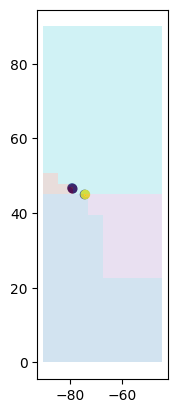

In [13]:
ax = shp_bug.plot(column='counts', cmap='viridis')
shp_part.plot(ax=ax,alpha=0.2,column='geohash_index')

In [11]:
shp_part

,index,geometry,geohash_index,counts
0,0,"POLYGON ((-67.50000 67.50000, -67.50000 73.125...",fs,0.0
1,1,"POLYGON ((-78.75000 67.50000, -78.75000 73.125...",fk,0.0
2,2,"POLYGON ((-56.25000 67.50000, -56.25000 73.125...",fu,0.0
3,3,"POLYGON ((-67.50000 61.87500, -67.50000 67.500...",fe,0.0
4,4,"POLYGON ((-78.75000 61.87500, -78.75000 67.500...",f7,0.0
...,...,...,...,...
127,31,"POLYGON ((-74.35547 44.99451, -74.35547 44.995...",drgpup0,0.0
15,15,"POLYGON ((-79.10431 46.72211, -79.10431 46.723...",f0r9zcw,119.0
43,11,"POLYGON ((-78.86948 46.52023, -78.86948 46.521...",f0rbtkc,59.0
69,5,"POLYGON ((-74.08493 44.99588, -74.08493 44.997...",drgrfpm,410.0


In [14]:
map_simple({'shp_part':shp_part})

(4, 4)